In [ ]:
!pip install bitsandbytes
!pip install -q -U git+https://github.com/huggingface/peft.git



  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
!pip install transformers
!pip install torch

In [ ]:
import os
import gc
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

import torch
import torch.nn as nn
import torchvision.transforms as torchvision_T
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
def order_points(pts):
    # Initialiser un tableau pour stocker les coins ordonnés
    rect = np.zeros((4, 2), dtype="float32")
    # Convertir les points d'entrée en un tableau numpy
    pts = np.array(pts)
    # Calculer la somme des coordonnées x et y de chaque point
    s = pts.sum(axis=1)
    # Trouver les coins supérieur gauche et inférieur droit en utilisant l'indice de somme minimale et maximale
    rect[0] = pts[np.argmin(s)]  # Coin supérieur gauche
    rect[2] = pts[np.argmax(s)]  # Coin inférieur droit

    # Calculer la différence des coordonnées x et y de chaque point
    diff = np.diff(pts, axis=1)
    # Trouver les coins supérieur droit et inférieur gauche en utilisant l'indice de différence minimale et maximale
    rect[1] = pts[np.argmin(diff)]  # Coin supérieur droit
    rect[3] = pts[np.argmax(diff)]  # Coin inférieur gauche
    # Convertir les coordonnées en entiers et les retourner sous forme de liste
    return rect.astype("int").tolist()



def find_dest(pts):
    # Désigner les coins du quadrilatère (coins du rectangle) à partir des points d'entrée
    (tl, tr, br, bl) = pts

    # Calculer les longueurs des côtés du rectangle
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Créer les coins de destination cible en fonction des longueurs calculées
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    # Ordonner les coins de destination et les retourner
    return order_points(destination_corners)


In [ ]:
def image_preproces_transforms(
    mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)
):
    common_transforms = torchvision_T.Compose(
        [torchvision_T.ToTensor(), torchvision_T.Normalize(mean, std),]
    )

    return common_transforms


"""La fonction load_model charge un modèle de segmentation d'image"""
def load_model(num_classes=1, checkpoint_path=None, device=None):
    model = deeplabv3_resnet50(num_classes=num_classes)
    model.to(device)
    checkpoints = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoints, strict=False)
    model.eval()

    _ = model(torch.randn((2, 3, 384, 384)).to(device))

    return model

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
CHECKPOINT_MODEL_PATH = r"/content/drive/MyDrive/model_r50_iou_mix_2C020 (1) (1).pth"
# Chargement du modèle MobileNetV3-Large avec 2 classes depuis le point de contrôle
trained_model = load_model(num_classes=2, checkpoint_path=CHECKPOINT_MODEL_PATH, device=device)
preprocess_transforms = image_preproces_transforms()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


In [ ]:
def extract(image_true=None, trained_model=None, image_size=384, BUFFER=10):
    global preprocess_transforms

    IMAGE_SIZE = image_size
    half = IMAGE_SIZE // 2

    imH, imW, C = image_true.shape

    image_model = cv2.resize(image_true, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

    scale_x = imW / IMAGE_SIZE
    scale_y = imH / IMAGE_SIZE

    image_model = preprocess_transforms(image_model)
    image_model = torch.unsqueeze(image_model, dim=0)

    image_model = image_model.to(next(trained_model.parameters()).device) # Add this line


    with torch.no_grad():
        out = trained_model(image_model)["out"].cpu()

    del image_model
    gc.collect()

    out = torch.argmax(out, dim=1, keepdims=True).permute(0, 2, 3, 1)[0].numpy().squeeze().astype(np.int32)
    r_H, r_W = out.shape

    _out_extended = np.zeros((IMAGE_SIZE + r_H, IMAGE_SIZE + r_W), dtype=out.dtype)
    _out_extended[half : half + IMAGE_SIZE, half : half + IMAGE_SIZE] = out * 255
    out = _out_extended.copy()

    del _out_extended
    gc.collect()

    # Edge Detection.
    canny = cv2.Canny(out.astype(np.uint8), 225, 255)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    contours, _ = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    page = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    # ==========================================
    epsilon = 0.02 * cv2.arcLength(page, True)
    corners = cv2.approxPolyDP(page, epsilon, True)

    corners = np.concatenate(corners).astype(np.float32)

    corners[:, 0] -= half
    corners[:, 1] -= half

    corners[:, 0] *= scale_x
    corners[:, 1] *= scale_y

    # check if corners are inside.
    # if not find smallest enclosing box, expand_image then extract document
    # else extract document

    if not (np.all(corners.min(axis=0) >= (0, 0)) and np.all(corners.max(axis=0) <= (imW, imH))):

        left_pad, top_pad, right_pad, bottom_pad = 0, 0, 0, 0

        rect = cv2.minAreaRect(corners.reshape((-1, 1, 2)))
        box = cv2.boxPoints(rect)
        box_corners = np.int32(box)
        #     box_corners = minimum_bounding_rectangle(corners)

        box_x_min = np.min(box_corners[:, 0])
        box_x_max = np.max(box_corners[:, 0])
        box_y_min = np.min(box_corners[:, 1])
        box_y_max = np.max(box_corners[:, 1])

        # Find corner point which doesn't satify the image constraint
        # and record the amount of shift required to make the box
        # corner satisfy the constraint
        if box_x_min <= 0:
            left_pad = abs(box_x_min) + BUFFER

        if box_x_max >= imW:
            right_pad = (box_x_max - imW) + BUFFER

        if box_y_min <= 0:
            top_pad = abs(box_y_min) + BUFFER

        if box_y_max >= imH:
            bottom_pad = (box_y_max - imH) + BUFFER

        # new image with additional zeros pixels
        image_extended = np.zeros((top_pad + bottom_pad + imH, left_pad + right_pad + imW, C), dtype=image_true.dtype)

        # adjust original image within the new 'image_extended'
        image_extended[top_pad : top_pad + imH, left_pad : left_pad + imW, :] = image_true
        image_extended = image_extended.astype(np.float32)

        # shifting 'box_corners' the required amount
        box_corners[:, 0] += left_pad
        box_corners[:, 1] += top_pad

        corners = box_corners
        image_true = image_extended

    corners = sorted(corners.tolist())
    corners = order_points(corners)
    destination_corners = find_dest(corners)
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))

    final = cv2.warpPerspective(image_true, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LANCZOS4)
    final = np.clip(final, a_min=0., a_max=255.)

    return final


uint8


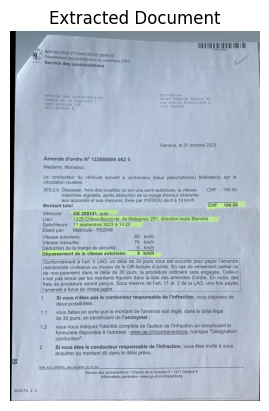

Extracted document saved at: /content/extracted_document_resnet50.jpg


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

image_path = "/content/WhatsApp Image 2024-03-15 at 12.08.41 (1).jpeg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)[:, :, ::-1]
print(image.dtype)

document = extract(image_true=image, trained_model=trained_model)

plt.imshow(document / 255.0)
plt.title("Extracted Document")
plt.axis('off')
plt.show()

output_path = "/content/extracted_document_resnet50.jpg"
document_uint8 = (document).astype('uint8')
cv2.imwrite(output_path, document_uint8)

print(f"Extracted document saved at: {output_path}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, None, None, 128)     │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN1 (BatchNormalization)             │ (None, None, None, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsample1 (UpSampling2D)             │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, None, None, 1)       │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,529 (588.00 KB)

 Trainable params: 150,273 (587.00 KB)

 Non-trainable params: 256 (1.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Denoised image saved at: denoised_image.png


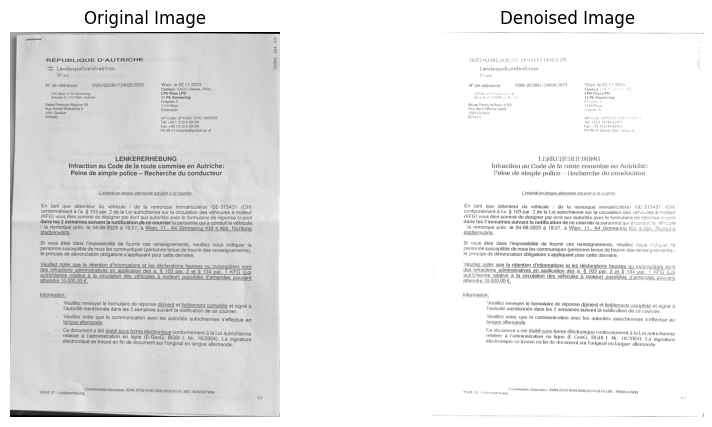

Returned path: denoised_image.png


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Input

# Assuming the model has already been trained as per your script
input_shape = (None, None, 1)

# Rebuild the model using functional API
inputs = Input(shape=input_shape)

# Encoder
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='Conv1')(inputs)
x = BatchNormalization(name='BN1')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool1')(x)

# Decoder
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='Conv2')(x)
x = UpSampling2D((2, 2), name='upsample1')(x)
outputs = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='Conv3')(x)

model = Model(inputs, outputs)
model.summary()

# Load the weights from the previously trained model
model.load_weights('/content/drive/MyDrive/denoising_autoencoder_80.h5')

# Function to preprocess a new image while keeping the original size
def preprocess_image(image_path):
    img = cv2.imread(image_path, 0)  # Load the image in grayscale
    img = img / 255.  # Normalize the pixel values
    img = np.expand_dims(img, axis=-1)  # Expand dimensions to fit the model input shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to denoise a single image
def denoise_single_image(image_path):
    preprocessed_image = preprocess_image(image_path)

    # Make a prediction on the new image
    denoised_image = model.predict(preprocessed_image)

    # Remove the batch dimension and channel dimension for display
    denoised_image = np.squeeze(denoised_image)

    # Save the denoised image
    denoised_image_path = 'denoised_image.png'
    cv2.imwrite(denoised_image_path, denoised_image * 255)  # Convert back to 0-255 range and save

    print(f'Denoised image saved at: {denoised_image_path}')

    # Display the original and denoised images
    original_image = cv2.imread(image_path, 0)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Denoised Image')
    plt.imshow(denoised_image, cmap='gray')
    plt.axis('off')

    plt.show()

    return denoised_image_path

# Test the function on a single image
test_image_path = '/content/extracted_document_resnet50.jpg'  # Change this to the path of your test image
denoised_image_path = denoise_single_image(test_image_path)
print(f'Returned path: {denoised_image_path}')


In [ ]:
# Import necessary libraries
from google.colab import drive
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel, PeftConfig
import torch
import os

In [ ]:
# Paths to the saved model in Google Drive
model_dir = "/content/drive/MyDrive/mistral_model"
peft_model_path = "/content/drive/MyDrive/peft-dialogue-summary1"

# Load the base model and tokenizer from Google Drive
base_model = AutoModelForCausalLM.from_pretrained(model_dir)
base_tokenizer = AutoTokenizer.from_pretrained(model_dir)
base_tokenizer.pad_token = base_tokenizer.eos_token
base_tokenizer.padding_side = "right"

# Paths to extracted model files for PEFT model

# Load Tokenizer for PEFT model
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)

# Load PEFT Config
peft_config = PeftConfig.from_pretrained(peft_model_path)

# Load the LoRA model on top of the base model
model = PeftModel.from_pretrained(base_model, peft_model_path)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def generate_summary(input_text):
    prompt = f"""### Instruction:
You are given a user utterance that may contain car penalty violation details.
You are also given a list of entity types representing Car Penalty Violation details.
Your task is to detect and identify all instances of the supplied Car Penalty Violation details entity types in the user utterance.
The JSON keys come from the car penalty violation details entities described in the list below.
For example, a registration of a car should be enclosed within a "registration" key. Ensure that all entities are identified. Do not perform false identifications.
If you don't know the answer, please don't share false information.

List Of Entities
id_penalty: Contravention notice number.
registration: Registration of a car.
date_time: Dates and Times of the offense.
location: Location of the offense.
description: Offense.
amount: Fine of the penalty.

Please provide the details in the following JSON format:
{{
  "id_penalty": "value",
  "registration": "value",
  "date_time": "value",
  "location": "value",
  "description": "value",
  "amount": "value"
}}

### utterance:
{input_text}
"""
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(model.device)

    outputs = model.generate(input_ids=input_ids, max_new_tokens=500)
    predicted_output = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):]

    return predicted_output

In [ ]:
import requests
import json
def ocr_space_file(filename, overlay=False, api_key='helloworld', language='fre'):
    payload = {
        'isOverlayRequired': overlay,
        'apikey': api_key,
        'language': language,
        'detectOrientation':True,
        'scale':True,
        'OCREngine': 2
    }
    with open(filename, 'rb') as f:
        r = requests.post(
            'https://api.ocr.space/parse/image',
            files={filename: f},
            data=payload,
        )
    result = json.loads(r.content.decode())  # Convert JSON response to Python object
    if 'ParsedResults' in result and len(result['ParsedResults']) > 0:
        extracted_text = result['ParsedResults'][0]['ParsedText']  # Extract parsed text
        return extracted_text
    else:
        return "No text extracted or error occurred"


# Use example with a local file
result_file = ocr_space_file(
    filename=denoised_image_path,
)
print(result_file)

REPUBLIQUE ET CANTON DE GENEVE
#1020
Département des institutions et du numérique (DIN)
MOT TACHER LES
Service des contraventions
Service des contraventions
Chemin de la Gravière 5
Ent reprise
Genève, le 31 octobre 2023
Amende d'ordre N° 123686006 062 5
Madame, Monsieur,
Le conducteur du véhicule suivant a contrevenu a/aux prescription(s) fédérale(s) sur la
circulation routière.
303.2.b Dépasser, hors des localités ou sur une semi-autoroute, la vitesse
CHF 100.00
maximale signalée, après déduction de la marge d'erreur inhérente
aux appareils et aux mesures, fixée par l'OFROU de 6 à 10 km/h
Montant total
CHF 100.00
Véhicule:
GE 305141, auto
Lieu:
1225 Chêne-Bourg rte. de Malagnou 251, direction route Blanche
Date/Heure: 11 septembre 2023 à 14:20
Etabli par:
Matricule - P02048
Vitesse autorisée:
60 km/h
Vitesse mesurée:
74 km/h
Déduction de la marge de sécurité:
-5 km/h
Dépassement de la vitesse autorisée:
9 km/h
Conformément à l'art. 6 LAO, un délai de 30 jours vous est accordé pour pay

In [ ]:
# Example input text
input_text = result_file

# Generate summary
summary = generate_summary(input_text)

# Print the result
dash_line = '-' * 100
print(dash_line)
print(f'INPUT TEXT:\n{input_text}')
print(dash_line)
print(f'PREDICTED OUTPUT:\n{summary}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


----------------------------------------------------------------------------------------------------
INPUT TEXT:
REPUBLIQUE ET CANTON DE GENEVE
#1020
Département des institutions et du numérique (DIN)
MOT TACHER LES
Service des contraventions
Service des contraventions
Chemin de la Gravière 5
Ent reprise
Genève, le 31 octobre 2023
Amende d'ordre N° 123686006 062 5
Madame, Monsieur,
Le conducteur du véhicule suivant a contrevenu a/aux prescription(s) fédérale(s) sur la
circulation routière.
303.2.b Dépasser, hors des localités ou sur une semi-autoroute, la vitesse
CHF 100.00
maximale signalée, après déduction de la marge d'erreur inhérente
aux appareils et aux mesures, fixée par l'OFROU de 6 à 10 km/h
Montant total
CHF 100.00
Véhicule:
GE 305141, auto
Lieu:
1225 Chêne-Bourg rte. de Malagnou 251, direction route Blanche
Date/Heure: 11 septembre 2023 à 14:20
Etabli par:
Matricule - P02048
Vitesse autorisée:
60 km/h
Vitesse mesurée:
74 km/h
Déduction de la marge de sécurité:
-5 km/h
Dépass